# CMIP6 AOPD/AOT comparison against ground-based and satellite remote sensing

- compare CMIP6 with MERRA2

### Visualiztion of AOD for Svalbard area 5E, 72N - 27E, 83N

In [1]:
from dask.distributed import Client

In [2]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='2GB')
client
chunks={
    'time' : 10,  
}
client 

Client Scheduler: tcp://127.0.0.1:35655 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 4.00 GB


In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
import pandas as pd
import pyaerocom as pya
from glob import glob
from functions import masked_average


pya.change_verbosity('critical', log=pya.const.print_log) # don't output warnings
pya.__version__

/opt/conda/lib/python3.7/site-packages/geonum/__init__.py:39: UserWarning: Plotting of maps etc. is deactivated, please install Basemap
  warn('Plotting of maps etc. is deactivated, please install Basemap')


'0.8.1.dev4'

In [4]:
# set plotting style
plt.style.use('ggplot')
sns.set_context('paper')
sns.set(font = 'Serif', font_scale = 1.8, )
sns.set_style('darkgrid',
                  {'font.family':'serif', #'font.serif':'Helvetica'
                   'grid.linestyle': '--'           },
                   )

In [5]:
## area which shall be used for AOD average
# should be similar as MERRA2 data
lllat = 75; lllon = -15
urlat = 82; urlon = 10

In [6]:
hist_path = 'shared-cmip6-for-ns1000k/historical/'
model_path = ['AWI-CM-1-1-MR', 'CESM2','EC-Earth3','GFDL-ESM4','IPSL-CM6A-LR',
              'NESM3', 'BCC-CSM2-MR', 'CESM2-WACCM', 'EC-Earth3-Veg', 'GISS-E2-1-G',
              'MCM-UA-1-0', 'NorCPM1','BCC-ESM1','CNRM-CM6-1','FGOALS-f3-L','GISS-E2-1-G-CC',
              'MIROC6','NorESM2-LM','CAMS-CSM1-0','CNRM-ESM2-1','FGOALS-g3','GISS-E2-1-H',
              'MIROC-ES2L','SAM0-UNICON','CanESM5','E3SM-1-0','GFDL-CM4','HadGEM3-GC31-LL',
              'MRI-ESM2-0','UKESM1-0-LL']

merra_path = 'g4.areaAvgTimeSeries.M2IMNXGAS_5_12_4_AODANA.19800101-20141231.15W_75N_10E_82N.csv' 
pyaero_path = '/home/notebook/shared-ns1000k/inputs/pyaerocom-testdata'

### Print all CMIP6 historical simulations including the AOD at 550nm (1850 - 2014)

In [7]:
for mp in range(len(model_path)):
    for _files in glob(hist_path + model_path[mp] + '/r*/od550aer_AERmon_*'):
        print(_files)

shared-cmip6-for-ns1000k/historical/CESM2/r1i1p1f1/od550aer_AERmon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc
shared-cmip6-for-ns1000k/historical/GFDL-ESM4/r1i1p1f1/od550aer_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc
shared-cmip6-for-ns1000k/historical/GFDL-ESM4/r1i1p1f1/od550aer_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_185001-194912.nc
shared-cmip6-for-ns1000k/historical/IPSL-CM6A-LR/r1i1p1f1/od550aer_AERmon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc
shared-cmip6-for-ns1000k/historical/CESM2-WACCM/r1i1p1f1/od550aer_AERmon_CESM2-WACCM_historical_r1i1p1f1_gn_185001-201412.nc
shared-cmip6-for-ns1000k/historical/CNRM-CM6-1/r1i1p1f2/od550aer_AERmon_CNRM-CM6-1_historical_r1i1p1f2_gr_185001-201412.nc
shared-cmip6-for-ns1000k/historical/NorESM2-LM/r1i1p1f1/od550aer_AERmon_NorESM2-LM_historical_r1i1p1f1_gn_194001-194912.nc
shared-cmip6-for-ns1000k/historical/NorESM2-LM/r1i1p1f1/od550aer_AERmon_NorESM2-LM_historical_r1i1p1f1_gn_193001-193912.nc
shared-cmip6-for-ns100

### Read all CMIP6 historical simulation including the AOD at 550nm (1980 - 2014)

In [8]:
cmip={}
for mp in range(len(model_path)):
    # loop over realisations (the r1ii)
    md_n = model_path[mp]
    cmip[md_n]={}
    for rea in glob(hist_path + model_path[mp]+'/*'):
        _r= rea.split('/')[-1]
        li_ds=[]
        fn_list = [fn for fn in glob(hist_path + model_path[mp]+ '/%s/od550aer_AERmon_*.nc'%_r) if (int(fn[-9:-5])>1980)]
        fn_areac= [fn for fn in glob(hist_path + model_path[mp]+ '/%s/areacella*.nc'%_r)]
#        print(fn_list)
        
        if len(fn_list)>0:
            _ds= xr.open_mfdataset(fn_list, chunks=chunks,parallel=True, use_cftime = True)#, compat='override')
            
            if len(fn_areac):
                _dsa = xr.open_dataset(fn_areac[0])
                _ds['areacella'] = _dsa['areacella']
            cmip[md_n][_r] = _ds#xr.merge([_ds, _dsa])
            ### Shift the longitude from 0 --> 360 to -180 --> 180
            
            cmip[md_n][_r] = cmip[md_n][_r].assign_coords(lon=(((cmip[md_n][_r].lon + 180) % 360) - 180)).sortby('lon').sortby('time')
            
        
        #    print(fn)
        #    endy= int(fn[-9:-5])
        #    if endy>1980:
        #        li_ds.append(xr.open_dataset(fn))
        #if len(li_ds)>0:
        #    cmip[md_n][_r]= xr.concat(li_ds, dim='time')
            
     


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/opt/conda/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/opt/conda/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'areacella' has multiple fill values {1e+

In [9]:
for mp in cmip.keys():
    for res in cmip[mp].keys():
        if 'areacella' not in cmip[mp][res]:
            print(mp)
            print(res)

CNRM-ESM2-1
r1i1p1f2
HadGEM3-GC31-LL
r1i1p1f3
UKESM1-0-LL
r1i1p1f2


# Plot selected area for chosen year of chosen model

In [10]:
choseny = '2006'

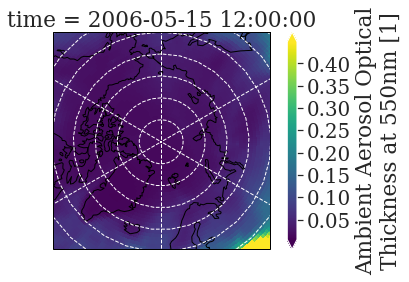

In [11]:
fig, ax = plt.subplots(1, #figsize = [30,13], 
                       subplot_kw={'projection': ccrs.AzimuthalEquidistant(central_longitude=0,
                                                                           central_latitude=90,)})
cmip['CESM2']['r1i1p1f1']['od550aer'].sel(time=choseny + '-05').plot(ax=ax,
                                                                     transform=ccrs.PlateCarree(),
                                                                     robust=True)
# Limit the map degrees latitude 
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

ax.coastlines()
ax.gridlines()

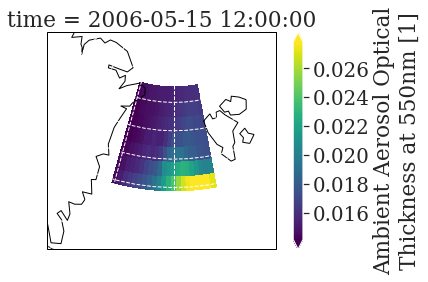

In [12]:
fig, ax = plt.subplots(1, #figsize = [30,13], 
                       subplot_kw={'projection': ccrs.AzimuthalEquidistant(central_longitude=0,
                                                                           central_latitude=90,)})
cmip['CESM2']['r1i1p1f1']['od550aer'].sel(time=choseny + '-05',
                                               lat=slice(lllat,urlat,1),
                                               lon=slice(lllon,urlon)).plot(ax=ax,
                                                                        transform=ccrs.PlateCarree(),
                                                                        robust=True)
# Limit the map degrees latitude 
ax.set_extent([-25, 20, 85, 71], ccrs.PlateCarree())

ax.coastlines()
ax.gridlines()
#plt.savefig('AOD_Svalbard.png')

## Read MERRA2 data 

In [13]:
starty = '1980'; endy = '2014'

In [14]:
merra_hist = pd.read_csv(merra_path, header = 7, index_col = 'time', parse_dates=True, 
                         skipinitialspace=True)

##### Rename the MERRA2 column

merra_hist.rename(columns={'mean_M2IMNXGAS_5_12_4_AODANA':'MERRA2'}, inplace=True)
merra_hist.shape

(420, 1)

## AOD CMIP6 weigted arctic average to the MERRA2: 
###  take only the data above chosen lower lat

In [15]:
for md in cmip.keys():
    for rea  in cmip[md].keys():
        #print(md, rea)
        try:
            aw_xr = cmip[md][rea]['areacella']
            mask  = cmip[md][rea]['lat'] <= (lllat-3)
            merra_hist.insert(loc=1,
                              column= md + '_' + rea,
                              value = masked_average(cmip[md][rea]['od550aer'].sel(time = slice(starty + '-01', endy + '12'),
                                                                                   lat = slice(lllat, urlat),
                                                                                   lon = slice(lllon, urlon)), 
                                                     dim=['lat','lon'], 
                                                     weights=aw_xr, 
                                                     mask=mask))
        except KeyError:
            print('no areacella data:', md+'_'+rea)

no areacella data: CNRM-ESM2-1_r1i1p1f2
no areacella data: HadGEM3-GC31-LL_r1i1p1f3
no areacella data: UKESM1-0-LL_r1i1p1f2


## Plot years with Volcanic eruptions, forest fires and Arctic haze

In [16]:
#choseny = '2006'    # arctic haze year in Russia forest fire
#choseny = '2004'     # arctic haze in Canada forest fire
#choseny = '1992'    # year after Pinatubo erruption
#### Russian Vulcano eruptions:
#choseny = '2010'     # Sarychev Peak 11-21 Jun 2009


cases_yr = [1992]
cases_yr.extend(np.arange(2004,2015))
cases_desc = ['yr after Mt. Pinatubo eruption',
              'Arctic haze, CAN forest fire',
              '',
               'Arctic haze, RUS forest fire',
              '', '', '', 
               'Sarychev Peak eruption',
              '', '','','']

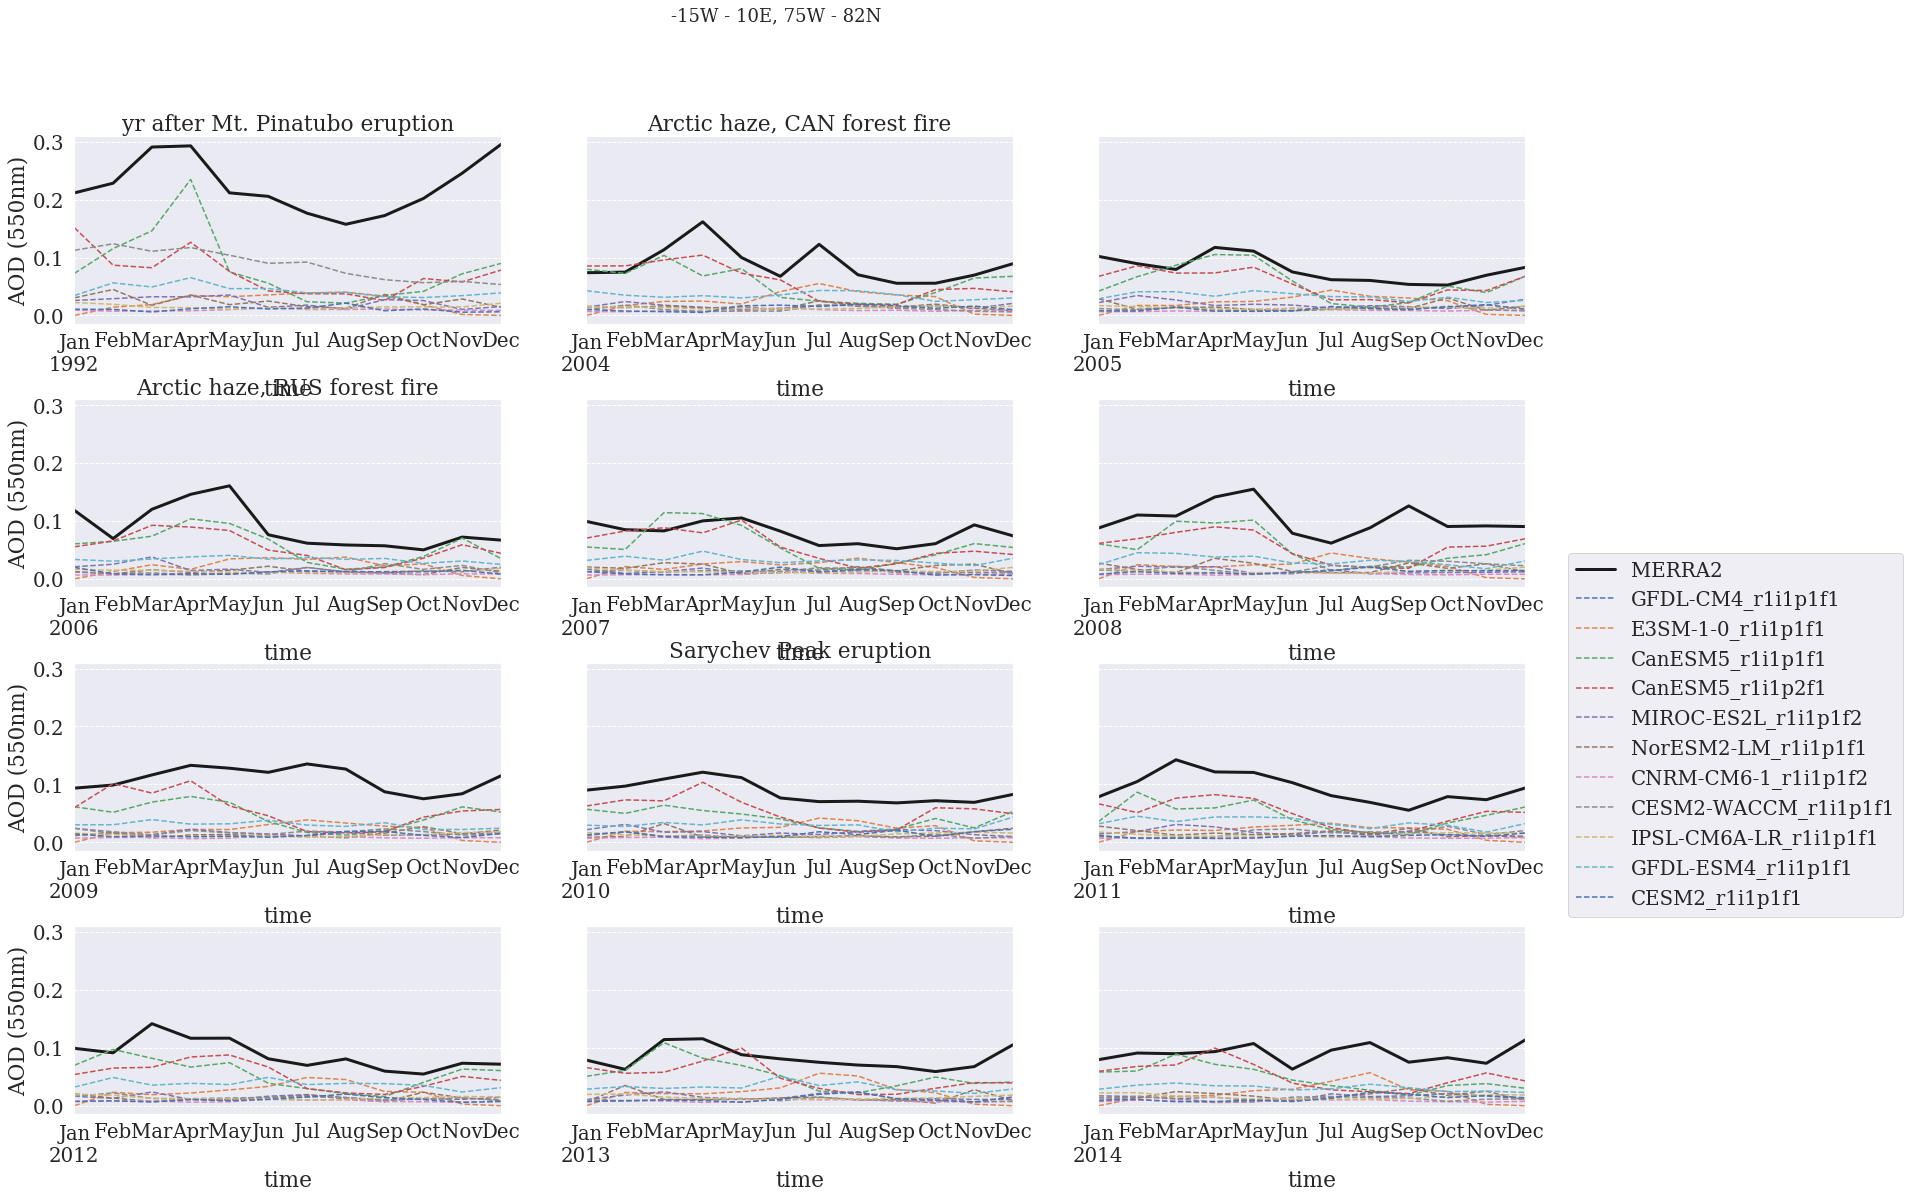

In [17]:
fig, axsm = plt.subplots(4, 3, #sharex='all',
                         sharey='all',
                         figsize=[26,18],
                        ) 

axs = axsm.flatten()
for i in range(len(cases_yr)):
    merra_hist['MERRA2'].loc[str(cases_yr[i]) + '-01' : str(cases_yr[i]) + '-12'].plot(ax=axs[i], 
                                                                          color = 'k', 
                                                                          linewidth=3)
    if i == len(cases_yr):
        merra_hist[merra_hist.columns[1:]].loc[str(cases_yr[i]) + '-01' : str(cases_yr[i]) + '-12'].plot(ax=axs[i], linestyle = '--', legend=True)
    else:
        merra_hist[merra_hist.columns[1:]].loc[str(cases_yr[i]) + '-01' : str(cases_yr[i]) + '-12'].plot(ax=axs[i], linestyle = '--', legend=False)
        
    axs[i].set_title(cases_desc[i])
    axs[i].set_ylabel('AOD (550nm)')

plt.suptitle('%sW - %sE, %sW - %sN' %(lllon,urlon,lllat,urlat));
axs[len(cases_yr)-1].legend(bbox_to_anchor=(1.1, 1.05), loc='lower left', borderaxespad=0., fancybox=True);
plt.subplots_adjust(wspace = 0.2,   # the amount of width reserved for blank space between subplots
                    hspace = 0.4   # the amount of height reserved for white space between subplots
                   )

## Plot median and std of AOD for 1980 - 2014

In [18]:
pd_median = merra_hist.loc[starty + '-01' : endy + '-12'].groupby(merra_hist.loc[starty + '-01': endy + '-12'].index.month).median()
pd_std = merra_hist.loc[starty + '-01' : endy + '-12'].groupby(merra_hist.loc[starty + '-01': endy + '-12'].index.month).std()

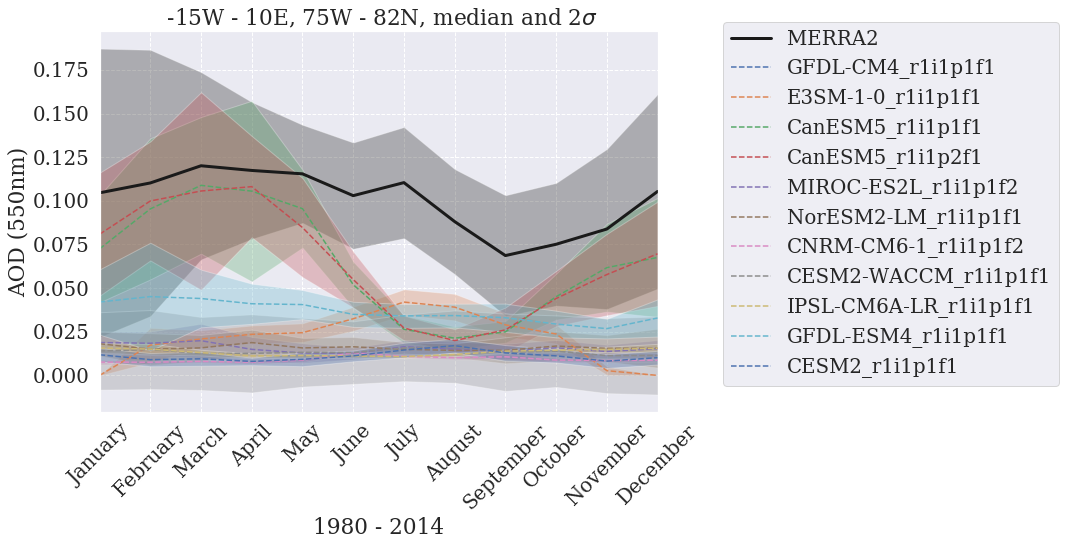

In [19]:
fig, ax = plt.subplots(1,figsize=[10,7])

pd_median['MERRA2'].plot(ax=ax, color = 'k', linewidth=3)
ax.fill_between(pd_median['MERRA2'].index, 
                (pd_median-pd_std)['MERRA2'], 
                (pd_median+pd_std)['MERRA2'],alpha=0.3,facecolor='k')

pd_median[pd_median.columns[1:]].plot(ax=ax, linestyle='--')
for i in range(1,pd_median.shape[1]):
    ax.fill_between(pd_median[pd_median.columns[i]].index,
                    pd_median[pd_median.columns[i]]-pd_std[pd_std.columns[i]],
                    pd_median[pd_median.columns[i]]+pd_std[pd_std.columns[i]], alpha=0.3)
ax.set_ylabel('AOD (550nm)')
ax.set_xlabel('%s - %s' %(starty,endy))
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(merra_hist.loc[starty + '-01' : endy + '-12'].index.month_name()[0:12], rotation=45)
ax.set_title(' %sW - %sE, %sW - %sN, median and 2$\sigma$' %(lllon,urlon,lllat,urlat))
ax.legend(bbox_to_anchor=(1.1, 1.05));

## Read in pyaerocom MODIS data

In [20]:
pya.const.BASEDIR = pyaero_path

In [21]:
pya.browse_database('*MODIS*')


Pyaerocom ReadGridded
---------------------
Data ID: MODIS6.aqua
Data directory: /home/notebook/shared-ns1000k/inputs/pyaerocom-testdata/obsdata/MODIS6.aqua/renamed
Available experiments: ['MODIS6.aqua']
Available years: [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Available frequencies ['daily']
Available variables: ['od550aer']


In [22]:
data = pya.io.ReadGridded('MODIS6.aqua').read_var('od550aer')
data

/opt/conda/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'od550aer' invalid units 'none'
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'od550aer' invalid units 'none'
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'od550aer' invalid units 'none'
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'od550aer' invalid units 'none'
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'od550aer' invalid units 'none'
  warnings.warn(msg)
/opt/conda/lib/pytho

pyaerocom.GriddedData
Grid data: <iris 'Cube' of Aerosol Optical Thickness at 0.55 microns for both Ocean (best) and Land (corrected): Mean / (unknown) (time: 4748; latitude: 180; longitude: 360)>

In [23]:
data.start

numpy.datetime64('2002-01-01T00:00:00.000000')

In [24]:
data.stop

numpy.datetime64('2014-12-31T23:59:59.999999')

In [25]:
xarr = data.to_xarray()
xarr

<xarray.DataArray 'od550aer' (time: 4748, lat: 180, lon: 360)>
dask.array<filled, shape=(4748, 180, 360), dtype=float64, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2002-01-01 00:00:00 ... 2014-12-31 00:00:00
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:                        Aerosol Optical Thickness at 0.55 micro...
    invalid_units:                    none
    nco_openmp_thread_number:         1
    NCO:                              4.4.4
    Aggregation_Data_Set:             None
    Derived_From_Level_2_Data_Set:    Optical_Depth_Land_And_Ocean
    Included_Level_2_Nighttime_Data:  False
    Level_2_Pixel_Values_Read_As:     Real
    Quality_Assurance_Data_Set:       None
    Statistic_Type:                   Simple
    valid_range:                      [-100 5000]
    from_files:                  

## Read in pyaerocom AOD for Arctic stations

In [26]:
aeronet_all = pya.io.ReadUngridded().read('AeronetSunV3Lev2.daily', 'od550aer')

In [27]:
aeronet_arctic = aeronet_all.apply_filters(latitude=(66, 90))   # find stations in the Arctic
aeronet_arctic.unique_station_names

['ARM_Oliktok_AK',
 'Abisko',
 'Andenes',
 'Barrow',
 'Hornsund',
 'Ittoqqortoormiit',
 'Kangerlussuaq',
 'Longyearbyen',
 'NEON_BARR',
 'NEON_TOOL',
 'North_Pole',
 'Ny_Alesund',
 'Ny_Alesund_AWI',
 'OPAL',
 'PEARL',
 'Resolute_Bay',
 'Sodankyla',
 'Thule',
 'Tiksi']

In [28]:
for station_name in aeronet_arctic.unique_station_names:
    print(aeronet_arctic.to_station_data(station_name)['station_name'], 
          aeronet_arctic.to_station_data(station_name)['longitude'],',',
          aeronet_arctic.to_station_data(station_name)['latitude'], 
          )

ARM_Oliktok_AK -149.88 , 70.4995
Abisko 18.817000000000004 , 68.35000000000001
Andenes 16.008611 , 69.27833299999998
Barrow -156.665 , 71.31219999999998
Hornsund 15.540279999999997 , 77.00148000000002
Ittoqqortoormiit -21.9512 , 70.48479999999999
Kangerlussuaq -50.6214 , 66.99580000000003
Longyearbyen 15.649 , 78.22283300000001
NEON_BARR -156.61936000000003 , 71.28241
NEON_TOOL -149.37046899999996 , 68.66108899999999
North_Pole 24.25433 , 88.80333
Ny_Alesund 11.86085 , 78.929433
Ny_Alesund_AWI 11.923040000000002 , 78.92316599999998
OPAL -85.939167 , 79.990278
PEARL -86.41694400000002 , 80.053611
Resolute_Bay -94.96940900000004 , 74.70512299999999
Sodankyla 26.629569999999998 , 67.36662
Thule -68.769001 , 76.516102
Tiksi 128.921417 , 71.58691699999999


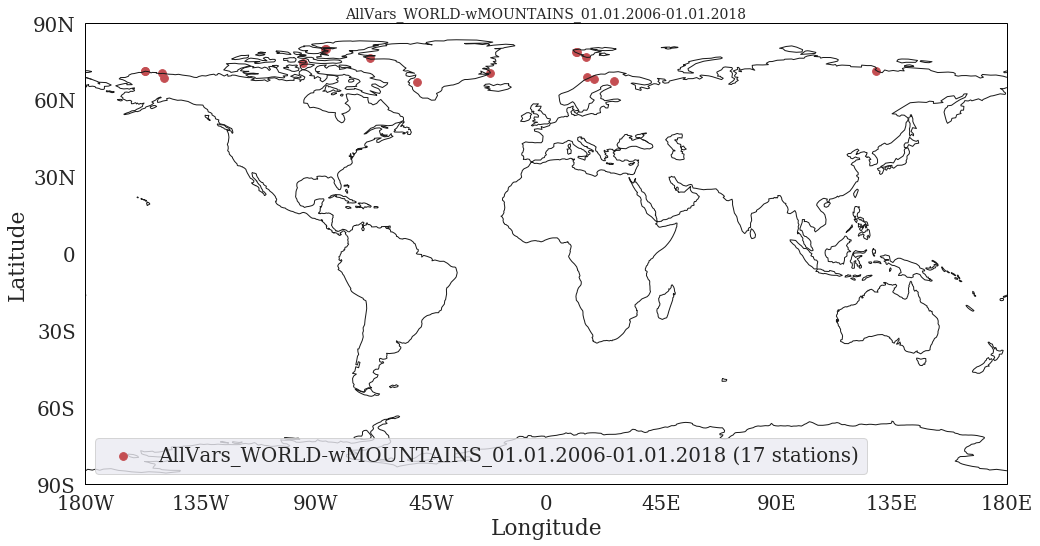

In [29]:
aeronet_arctic.plot_station_coordinates(markersize=60, start=2006, stop=2018)

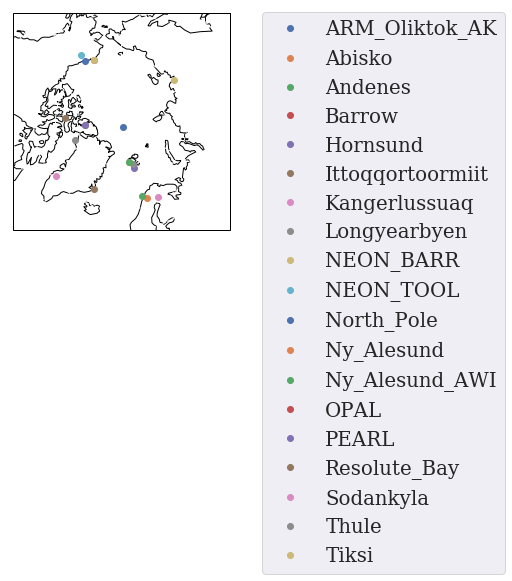

In [30]:
fig, ax = plt.subplots(1, #figsize = [30,13], 
                       subplot_kw={'projection': ccrs.AzimuthalEquidistant(central_longitude=0,
                                                                           central_latitude=90,)})

for station_name in aeronet_arctic.unique_station_names:
    ax.plot([aeronet_arctic.to_station_data(station_name)['longitude'],],
            [aeronet_arctic.to_station_data(station_name)['latitude']], 'o', transform=ccrs.PlateCarree(),label=aeronet_arctic.to_station_data(station_name)['station_name'])#robust=True)
# Limit the map degrees latitude 
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

ax.coastlines()
ax.gridlines()
ax.legend(bbox_to_anchor=(1.1, 1.05));

/opt/conda/lib/python3.7/site-packages/pyaerocom-0.8.1.dev4-py3.7.egg/pyaerocom/helpers.py:493: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[how][invalid] = np.nan


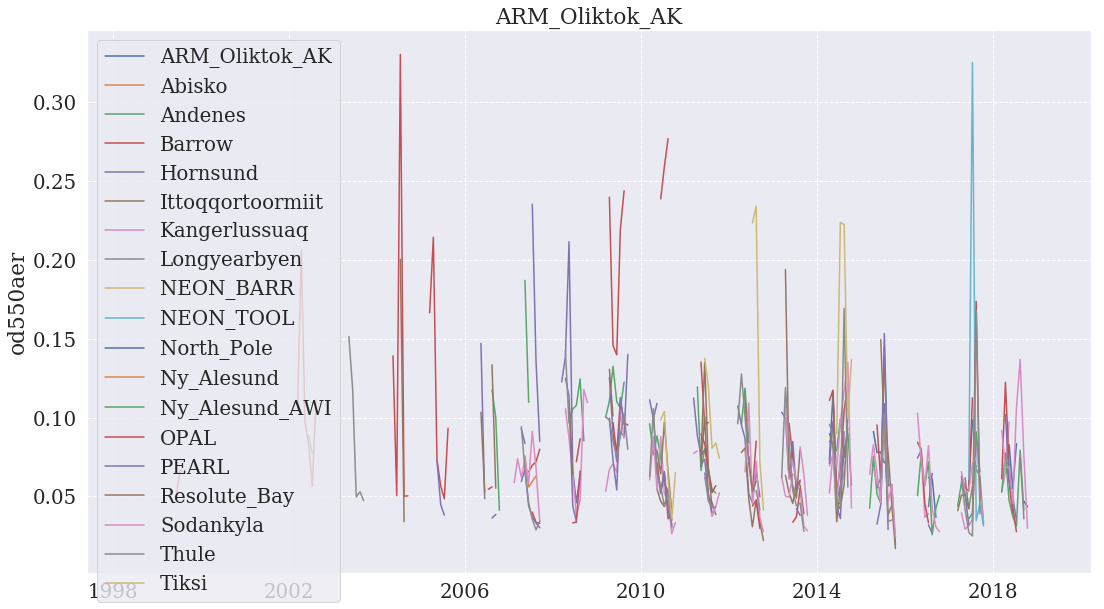

In [31]:
aeronet_arctic.unique_station_names
fig, ax = plt.subplots(1,1, figsize=(18, 10))
for station_name in aeronet_arctic.unique_station_names:
    station_data = aeronet_arctic.to_station_data(station_name)
    station_data.plot_timeseries('od550aer', freq='monthly', label=station_name, ax=ax)

plt.legend()

In [32]:
merra_stat = pd.DataFrame({'' : []})
for station_name in aeronet_arctic.unique_station_names:
    _long = aeronet_arctic.to_station_data(station_name)['longitude']
    _lat  = aeronet_arctic.to_station_data(station_name)['latitude']
    if _long <0:
        _dir = 'W'
#        print('west')
    if _long >0:
        _dir = 'E'
 #       print('east')
    fn = glob('g4.areaAvgTimeSeries.M2IMNXGAS_5_12_4_AODANA.2006*%s%s_%sN.csv' 
          %(str(int(abs(_long))), 
            _dir,
            str(int(_lat))))
#    print(station_name, str(int(_long)), str(int(_lat)))
 #   print(fn)
      
    _df = pd.read_csv(fn[0], header=7, index_col = 'time', parse_dates=True, skipinitialspace=True)
    merra_stat.insert(loc=1, column= station_name, value=_df[_df.columns[0]])

In [33]:
merra_stat = merra_stat.drop(columns='')

In [34]:
## transform aerocom data to xarray
xr_arctic = {}

for station_name in aeronet_arctic.unique_station_names:
    xr_arctic[station_name] = {}
    xr_arctic[station_name]['od550aer'] = aeronet_arctic.to_station_data(station_name)['od550aer'].to_xarray()

In [35]:
## calculate median and std of the aerocom data
for station_name in xr_arctic.keys():
    if len(xr_arctic[station_name]['od550aer'].sel(index= slice('2006-01', '2014-12'))) >0:
        xr_arctic[station_name]['median'] = xr_arctic[station_name]['od550aer'].sel(index= slice('2006-01', '2014-12')).groupby('index.month').median()
        xr_arctic[station_name]['std']    = xr_arctic[station_name]['od550aer'].sel(index= slice('2006-01', '2014-12')).groupby('index.month').std()

In [36]:
## calculate median and std of the MERRA2 data
merra_stat_median = merra_stat.loc['2006-01': '2014-12'].groupby(merra_stat.loc['2006-01': '2014-12'].index.month).median()
merra_stat_std    = merra_stat.loc['2006-01': '2014-12'].groupby(merra_stat.loc['2006-01': '2014-12'].index.month).std()

In [37]:
## use only valid data for 2006 - 2014
station_names = []
for station_name in xr_arctic.keys():
    if len(xr_arctic[station_name]['od550aer'].sel(index= slice('2006-01', '2014-12'))) >0:
        station_names.append(station_name)

## Plot Arctic stations with valid data 
compare MERRA2 to Aerocom

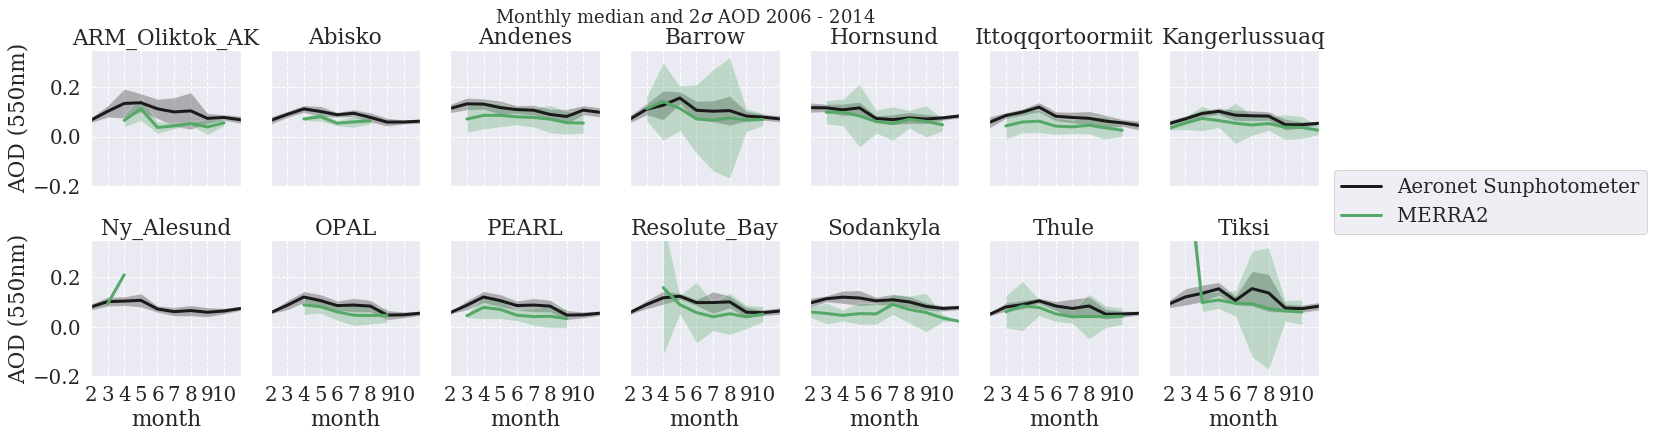

In [38]:
fig, axsm = plt.subplots(2, 7, sharex='all',
                         sharey='all',
                         figsize=[22,6],
                        ) 
axs = axsm.flatten()

for station_name, i in zip(station_names, range(len(aeronet_arctic.unique_station_names))):
 #   if len(xr_arctic[station_name]['od550aer'].sel(index= slice('2006-01', '2014-12'))) >0:
     #   xr_arctic[station_name]['od550aer'].sel(index=slice('2006-01', '2014-12')).plot(ax=axs[i], )
    merra_stat_median[station_name].plot(ax=axs[i], color = 'k', linewidth=3)
    axs[i].fill_between(merra_stat_median.index, 
                        merra_stat_median[station_name] - merra_stat_std[station_name],
                        merra_stat_median[station_name] + merra_stat_std[station_name], alpha=0.3,facecolor='k')
    
    
    xr_arctic[station_name]['median'].plot(ax=axs[i],color = 'g', linewidth=3)
    axs[i].fill_between(xr_arctic[station_name]['median'].month, 
                (xr_arctic[station_name]['median'] - xr_arctic[station_name]['std']), 
                (xr_arctic[station_name]['median'] + xr_arctic[station_name]['std']),alpha=0.3,facecolor='g')
    
    
    
    axs[i].set_title(station_name)
    axs[i].set_xlim([2,11])
    axs[i].set_ylim([-0.2,0.35])
    axs[i].set_xticks(np.arange(2,11))
    axs[i].set_ylabel('AOD (550nm)')
    axs[i].set_xlabel('month')
plt.suptitle('Monthly median and 2$\sigma$ AOD 2006 - 2014')
axs[len(station_names)-1].legend(['Aeronet Sunphotometer', 'MERRA2'],bbox_to_anchor=(1.1, 1.05), loc='lower left', borderaxespad=0., fancybox=True);
#handles, labels = ax.get_legend_handles_labels()
#fig.legend([], labels, loc='upper center')
plt.subplots_adjust(wspace = 0.2,   # the amount of width reserved for blank space between subplots
                    hspace = 0.4   # the amount of height reserved for white space between subplots
                   )

## Pick grid cells closest to measuring stations and create median and std

In [39]:
cmip_st = {}
for md in cmip.keys():
    cmip_st[md] = {}
    for rea in cmip[md].keys():
        cmip_st[md][rea] = {}
        for station_name in station_names:
            cmip_st[md][rea][station_name] = {}
           # print(md, rea, station_name)
            _loc_near = cmip[md][rea]['od550aer'].sel( lat = aeronet_arctic.to_station_data(station_name)['latitude'], 
                                            lon = aeronet_arctic.to_station_data(station_name)['longitude'], method='nearest')
            cmip_st[md][rea][station_name] = _loc_near.sel(time=slice('2006-01', '2014-12'),).groupby('time.month').std().to_dataframe().rename(columns={'od550aer':'std'})
            cmip_st[md][rea][station_name].insert(loc=3, column='median',
                                                  value=_loc_near.sel(time=slice('2006-01', '2014-12'),).groupby('time.month').reduce(np.nanpercentile, 
                                                                                                  dim='time',
                                                                                                  q=0.5).to_dataframe()['od550aer'])

/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overw

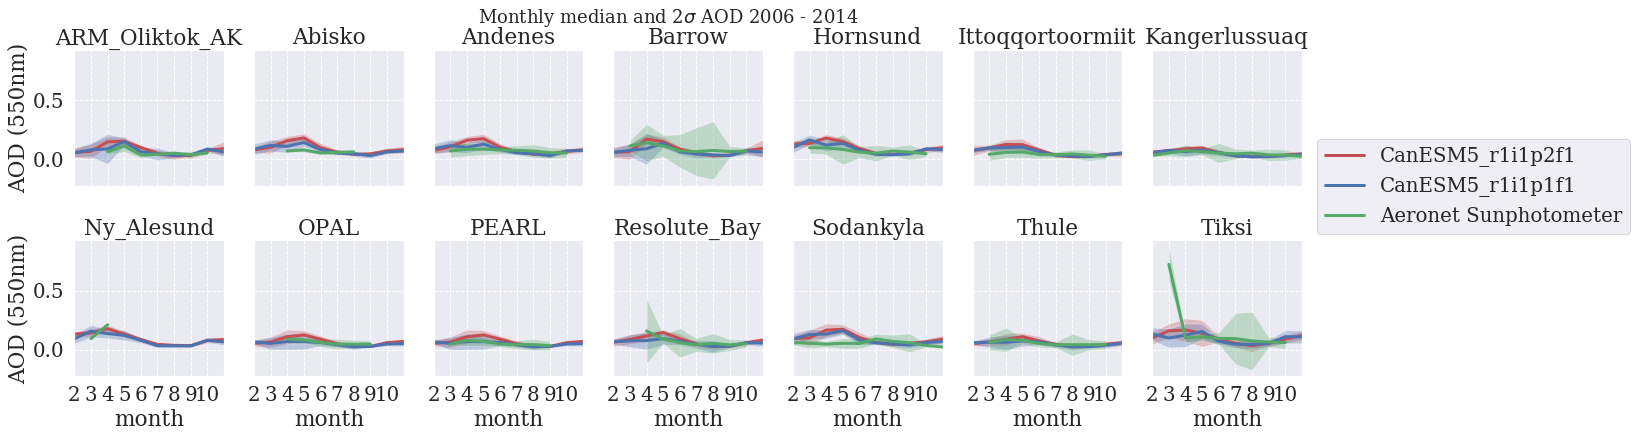

In [40]:
fig, axsm = plt.subplots(2, 7, sharex='all',
                         sharey='all',
                         figsize=[22,6],
                        ) 
axs = axsm.flatten()

for station_name, i in zip(station_names, range(len(aeronet_arctic.unique_station_names))):
    cmip_st['CanESM5']['r1i1p2f1'][station_name]['median'].plot(ax=axs[i],color = 'r', linewidth=3)
    axs[i].fill_between(cmip_st['CanESM5']['r1i1p2f1'][station_name]['median'].index, 
                        cmip_st['CanESM5']['r1i1p2f1'][station_name]['median'] - cmip_st['CanESM5']['r1i1p2f1'][station_name]['std'],
                        cmip_st['CanESM5']['r1i1p2f1'][station_name]['median'] + cmip_st['CanESM5']['r1i1p2f1'][station_name]['std'],
                        alpha=0.3,facecolor='r')
    
    cmip_st['CanESM5']['r1i1p1f1'][station_name]['median'].plot(ax=axs[i],color = 'b', linewidth=3)
    axs[i].fill_between(cmip_st['CanESM5']['r1i1p1f1'][station_name]['median'].index, 
                        cmip_st['CanESM5']['r1i1p1f1'][station_name]['median'] - cmip_st['CanESM5']['r1i1p1f1'][station_name]['std'],
                        cmip_st['CanESM5']['r1i1p1f1'][station_name]['median'] + cmip_st['CanESM5']['r1i1p1f1'][station_name]['std'],
                        alpha=0.3,facecolor='b')
    
    xr_arctic[station_name]['median'].plot(ax=axs[i],color = 'g', linewidth=3)
    axs[i].fill_between(xr_arctic[station_name]['median'].month, 
                (xr_arctic[station_name]['median'] - xr_arctic[station_name]['std']), 
                (xr_arctic[station_name]['median'] + xr_arctic[station_name]['std']),alpha=0.3,facecolor='g')
    
    
    axs[i].set_title(station_name)
    axs[i].set_xlim([2,11])
#    axs[i].set_ylim([-0.2,0.35])
    axs[i].set_xticks(np.arange(2,11))
    axs[i].set_ylabel('AOD (550nm)')
    axs[i].set_xlabel('month')
plt.suptitle('Monthly median and 2$\sigma$ AOD 2006 - 2014')
axs[len(station_names)-1].legend(['CanESM5_r1i1p2f1', 'CanESM5_r1i1p1f1', 'Aeronet Sunphotometer'],bbox_to_anchor=(1.1, 1.05), loc='lower left', borderaxespad=0., fancybox=True);
#handles, labels = ax.get_legend_handles_labels()
#fig.legend([], labels, loc='upper center')
plt.subplots_adjust(wspace = 0.2,   # the amount of width reserved for blank space between subplots
                    hspace = 0.4   # the amount of height reserved for white space between subplots
                   )

In [ ]:
cmip['CanESM5']['r1i1p1f1'].sel(time = slice('2006-01', '2014-12')).groupby('time.month')
                   #             lat = aeronet_arctic.to_station_data(station_name)['latitude'],
                    #            lon = aeronet_arctic.to_station_data(station_name)['longitude'],
                     #           method = 'nearest')#.groupby('time.month')

In [ ]:
cmip['CanESM5']['r1i1p1f1'].sel(time=slice('2006-01','2014-12')).sel(
                                lat = aeronet_arctic.to_station_data(station_name)['latitude'],
                                lon = aeronet_arctic.to_station_data(station_name)['longitude'],
                                method = 'nearest').groupby('time.month')

In [ ]:
CAN = {}
cmip = merra_hist['CanESM5_r1i1p1f1'].loc['2006-01': '2014-12'].groupby(merra_stat.loc['2006-01': '2014-12'].index.month).median()

In [ ]:
merra_hist['CanESM5_r1i1p2f1']

## Generate report
!jupyter nbconvert --to html --template ./clean_output.tpl franzihe_area_averaged_AO.ipynb
!jupyter nbconvert --to md --template ./clean_output.tpl franzihe_area_averaged_AO.ipynb